In [45]:
import os
import jax
import yaml
import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
from jax.numpy import pi
from functools import partial

In [46]:
def yaml_parse(yaml_filepath):     
    with open(yaml_filepath) as f:
        args = yaml.load(f, Loader=yaml.FullLoader)
        print(f"YAML parameters:")
        print(yaml.dump(args, default_flow_style=False))
    return args

In [47]:
case_name = 'ice'
work_path = os.getcwd()
case_path = work_path + os.sep + case_name
if not os.path.exists(case_path):
    os.makedirs(case_path)
    print(f"Directory '{case_name}' created at work_path.")
else:
    print(f"Directory '{case_name}' already exists at work_path.")
    for file in os.listdir(case_path):
        f = case_path + os.sep + file
        if os.path.isfile(f):
            os.remove(f)
            
args = yaml_parse(os.path.join(work_path, '%s.yaml' %(case_name))) 

Directory 'ice' already exists at work_path.
YAML parameters:
J: 6
K: 1.2
T_eq: 1.0
a: 0.01
alpha: 0.9
delta: 0.04
dt: 0.0002
eps_bar: 0.01
gamma: 10.0
hx: 0.03
hy: 0.03
nx: 500
ny: 500
t_OFF: 0.28
tou: 0.0003



In [48]:
dt = args['dt']
t_OFF = args['t_OFF']
hx = args['hx']
hy = args['hy']
nx = args['nx']
ny = args['ny']
K = args['K']
tou = args['tou']
T_eq = args['T_eq']
gamma = args['gamma']
alpha = args['alpha']
a = args['a']
J = args['J']
delta = args['delta']
eps_bar = args['eps_bar']

t = 0.
nIter = int(t_OFF/dt)

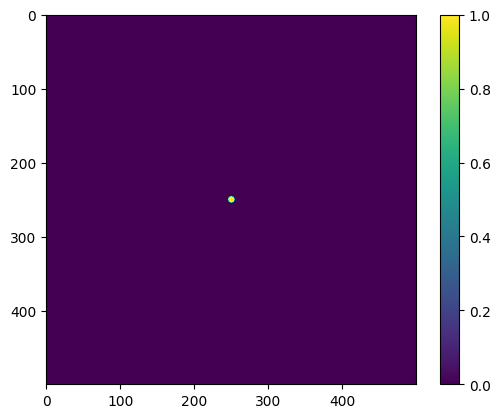

In [49]:
# Initializing
T = np.zeros((nx,ny))
p = np.zeros((nx,ny))
theta = np.zeros((nx,ny))
p_x = np.zeros((nx,ny))
p_y = np.zeros((nx,ny))
eps = np.zeros((nx,ny))
eps_der = np.zeros((nx,ny))
eps2_x = np.zeros((nx,ny))
eps2_y = np.zeros((nx,ny))

'''circle'''
i, j = onp.meshgrid(onp.arange(nx), onp.arange(ny))
mask =  ((i - nx/2.)**2 + (j - ny/2.)**2) < 20.
p = p.at[mask].set(1.)
'''hexagon'''
# x0, y0, L = nx//2, ny//2, 10
# lk = -1 / np.sqrt(3)
# b0 = y0-L+x0/np.sqrt(3)
# b1 = L+y0+x0/np.sqrt(3)
# b2 = y0-L-x0/np.sqrt(3)
# b3 = y0+L-x0/np.sqrt(3)
# for i in range(nx):
#     for j in range(ny):
#         if i>=x0-L and i<=x0+L and j<=b1+lk*i and j>=b2-lk*i and j<=b3-lk*i and j>=b0+lk*i:
#             p[i,j] = 1.
            
plt.imshow(p, cmap='viridis')
plt.colorbar()
plt.show()

In [50]:
@partial(jax.jit, static_argnums=(1,2))
def grad(m, dx, dy):
    m_neg_x = np.concatenate((m[:, :1], m[:, :-1]), axis=1)
    m_pos_x = np.concatenate((m[:, 1:], m[:, -1:]), axis=1)
    m_neg_y = np.concatenate((m[:1, :], m[:-1, :]), axis=0)
    m_pos_y = np.concatenate((m[1:, :], m[-1:, :]), axis=0)
    
    f_x = (m_pos_x - m_neg_x) / 2. /dx
    f_y = (m_pos_y - m_neg_y) / 2. /dy
    return f_x, f_y

@partial(jax.jit, static_argnums=(1,2))
def laplace(m, hx, hy):
    m_neg_x = np.concatenate((m[:, :1], m[:, :-1]), axis=1)
    m_pos_x = np.concatenate((m[:, 1:], m[:, -1:]), axis=1)
    m_neg_y = np.concatenate((m[:1, :], m[:-1, :]), axis=0)
    m_pos_y = np.concatenate((m[1:, :], m[-1:, :]), axis=0)
    return (m_neg_x + m_pos_x - 2.*m)/hx**2 + (m_neg_y + m_pos_y - 2.*m)/hy**2

In [51]:
@partial(jax.jit)
def get_theta(angle, f_x, f_y):
    theta = np.zeros_like(angle)
    mask = (f_x == 0) & (f_y > 0)
    theta = np.where(mask, .5*pi, theta)
    mask = (f_x == 0) & (f_y < 0)
    theta = np.where(mask, -.5*pi, theta)
    mask = (f_x > 0) & (f_y < 0)
    theta = np.where(mask, 2*pi + np.arctan(f_y/f_x), theta)
    mask = (f_x > 0) & (f_y > 0)
    theta = np.where(mask, np.arctan(f_y/f_x), theta)
    mask = (f_x < 0)
    theta =  np.where(mask, pi + np.arctan(f_y/f_x), theta)
    return theta

@partial(jax.jit)
def get_eps(angle):
    return eps_bar*(1 + delta*np.cos(J*angle)), -eps_bar*J*delta*np.sin(J*angle)

In [52]:
@partial(jax.jit, static_argnums=(0,1))
def phase_field(dx, dy, eps, eps_der, p_x, p_y, p, T):    
    part1, _ = grad(eps*eps_der*p_y, dx, dy)
    _, part2 = grad(eps*eps_der*p_x, dx, dy)
    part3 = eps2_x*p_x + eps2_y*p_y
    
    m = alpha / np.pi * np.arctan(gamma*(T_eq-T))
    term1 = -part1+part2+part3 + eps**2 * laplace(p, dx, dy)
    term2 = p*(1-p)*(p-0.5+m)
    chi = jax.random.uniform(jax.random.PRNGKey(0), shape=p.shape) - 0.5
    noise = a * p * (1-p) * chi
    
    p_new = p + dt/tou*(term1 + term2)
    mask = (p <= 0.5) & (p >= 0.)
    return np.where(mask, p_new+noise, p_new)

In [53]:
@partial(jax.jit)
def T_field(T, d_eta):
    return T + dt*laplace(T,hx,hy) + K*d_eta

In [54]:
@partial(jax.jit)
def zero_flux_BC(arr):
    arr = arr.at[0,:].set(arr[1,:])
    arr = arr.at[:,0].set(arr[:,1])
    arr = arr.at[-1,:].set(arr[-2,:])
    arr = arr.at[:,-1].set(arr[:,-2])
    return arr

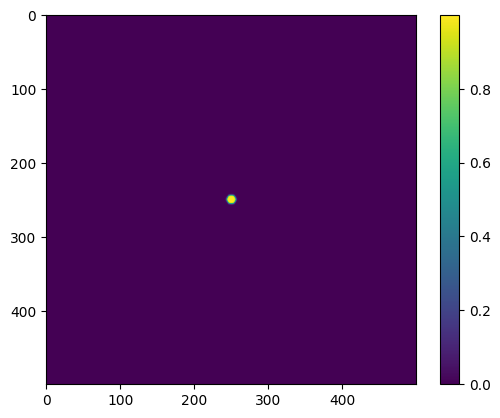

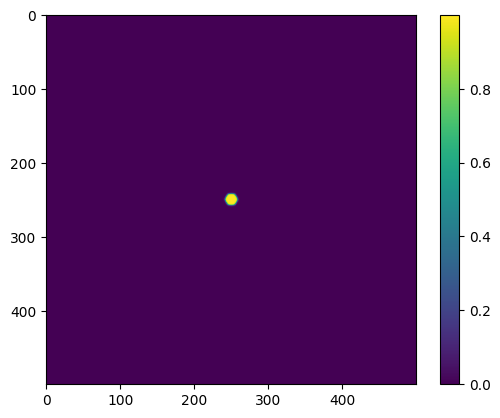

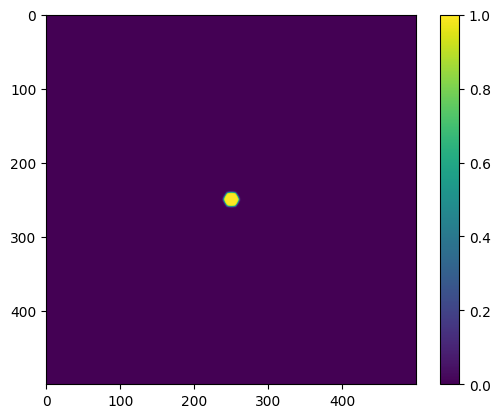

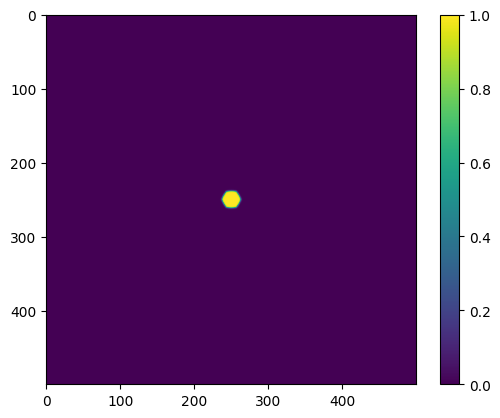

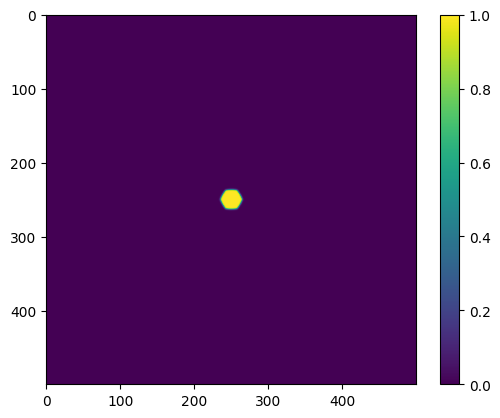

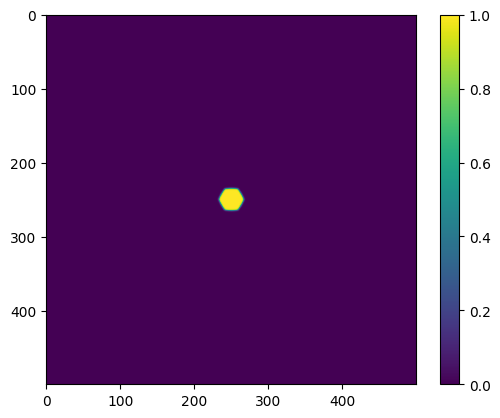

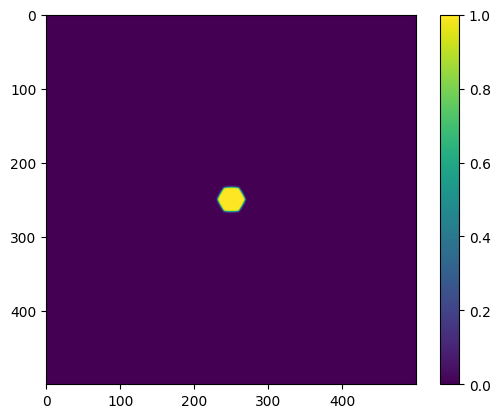

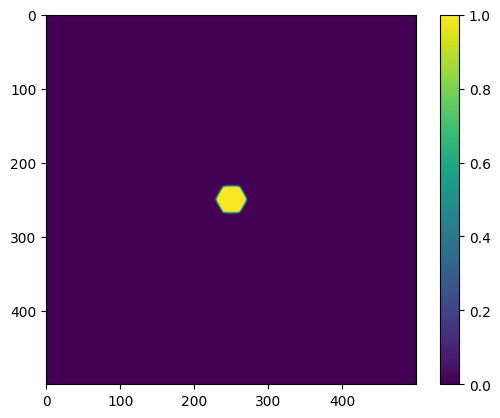

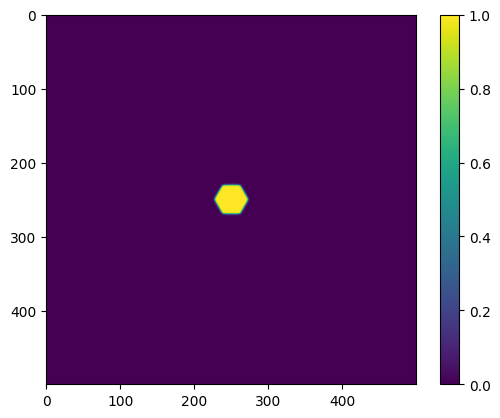

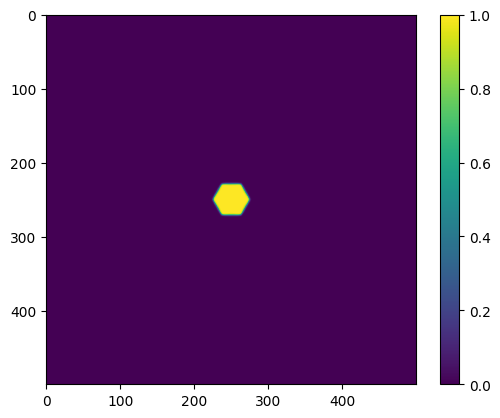

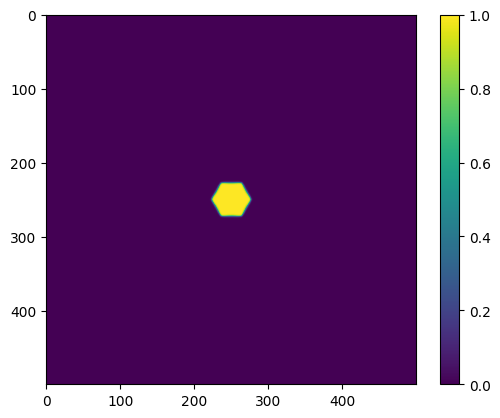

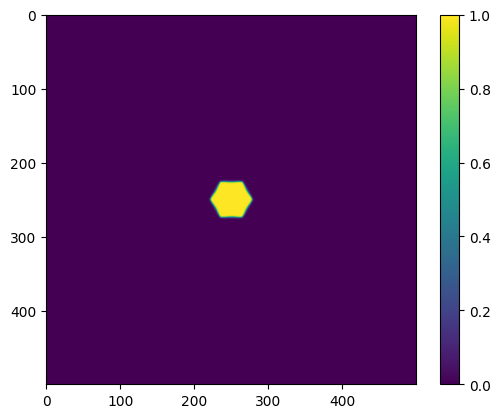

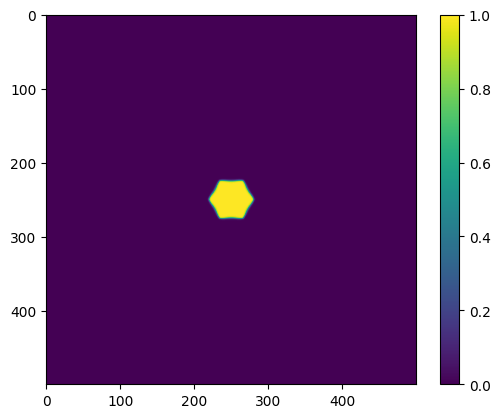

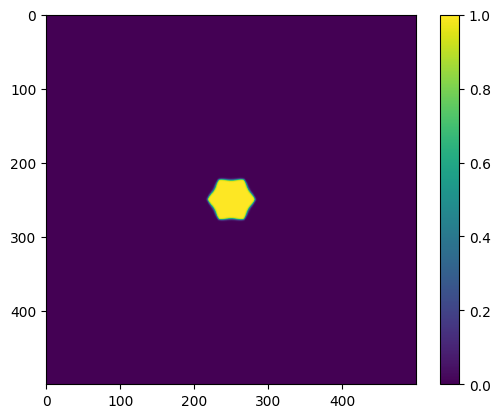

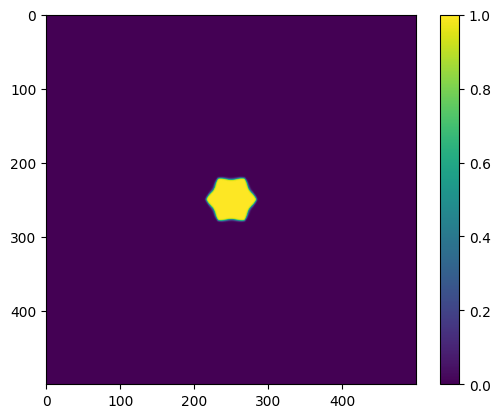

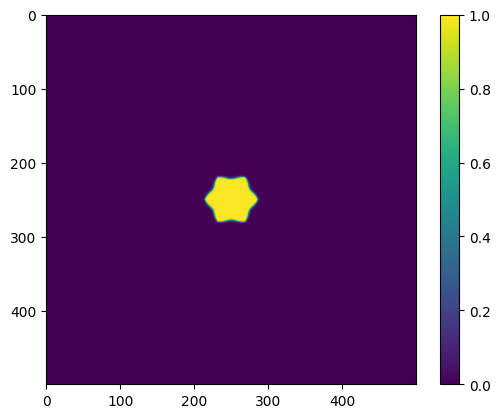

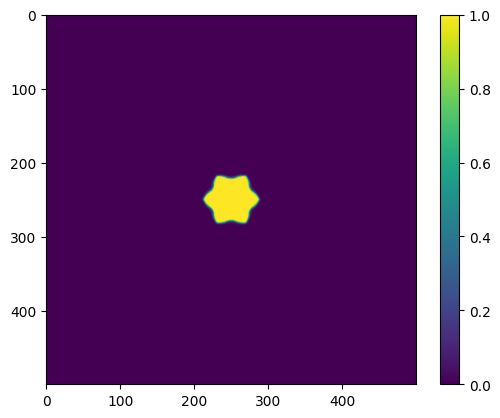

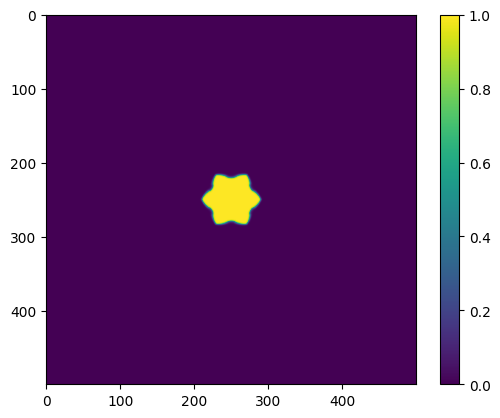

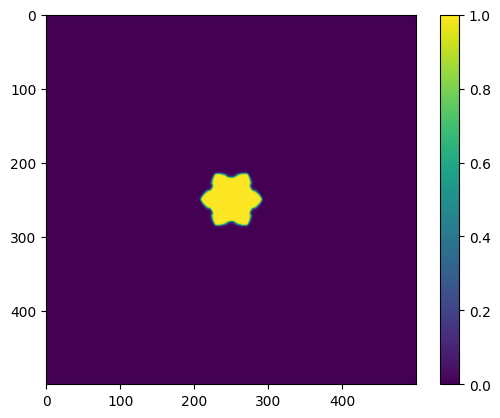

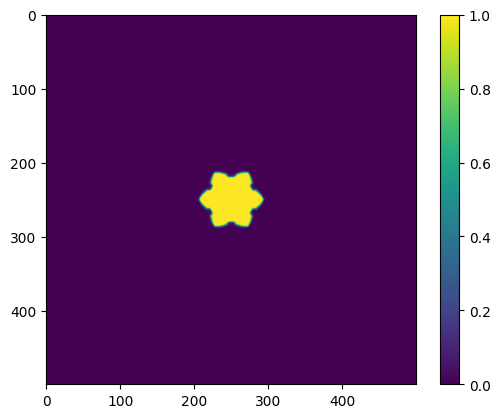

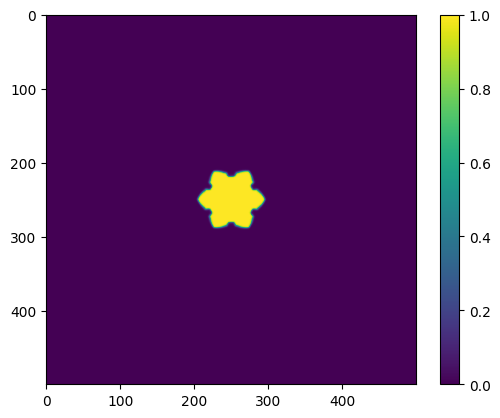

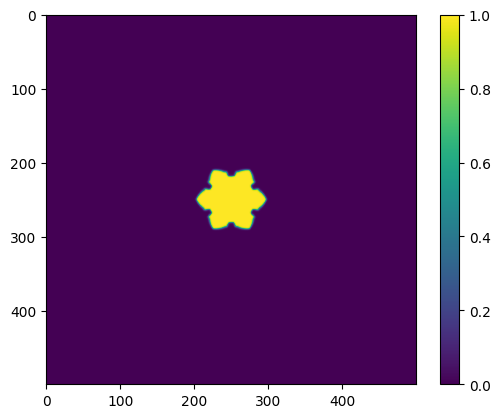

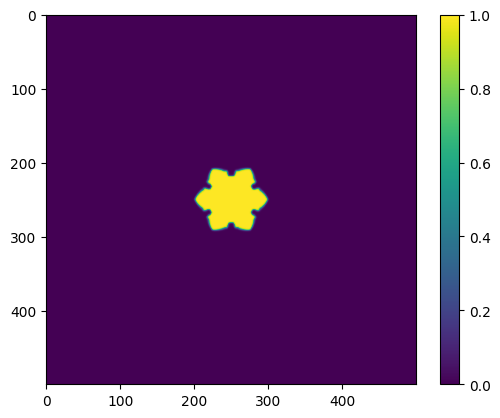

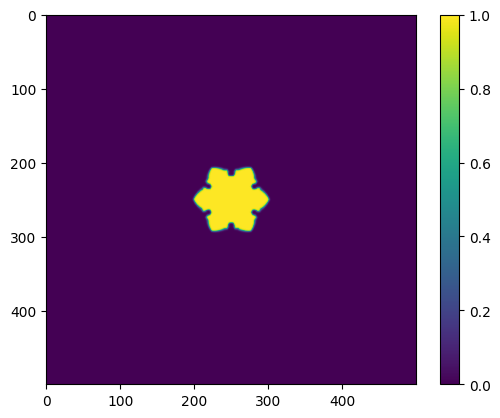

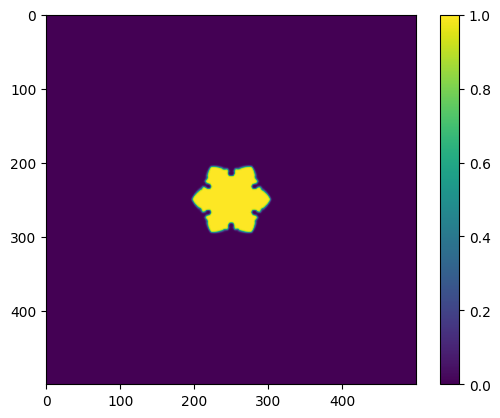

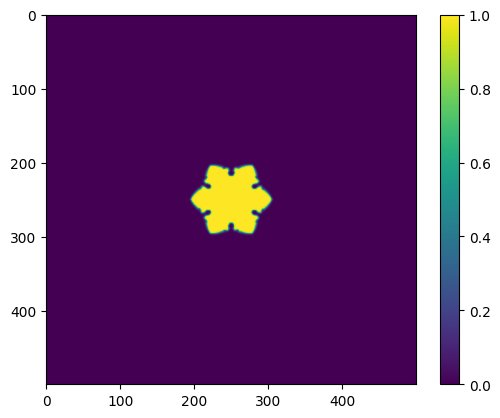

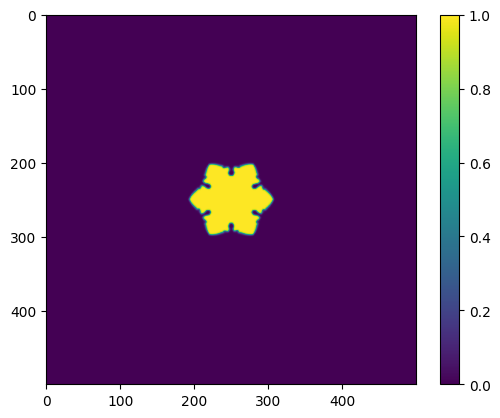

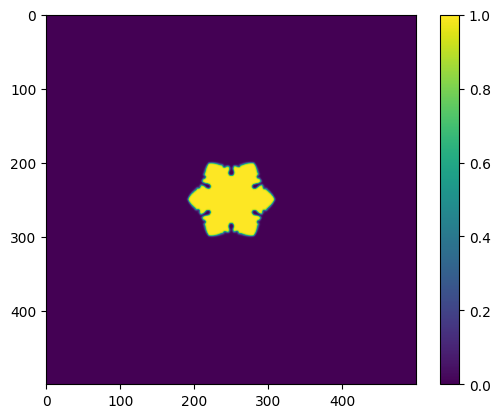

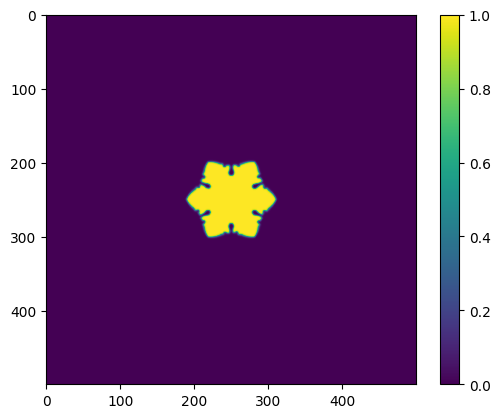

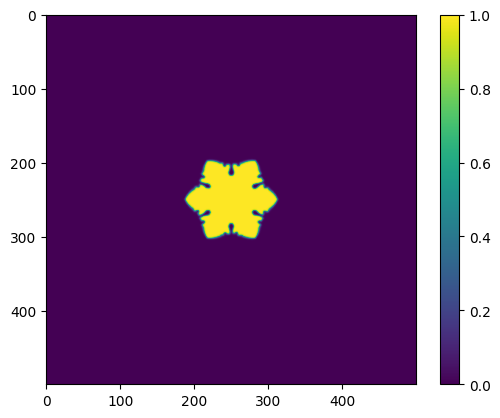

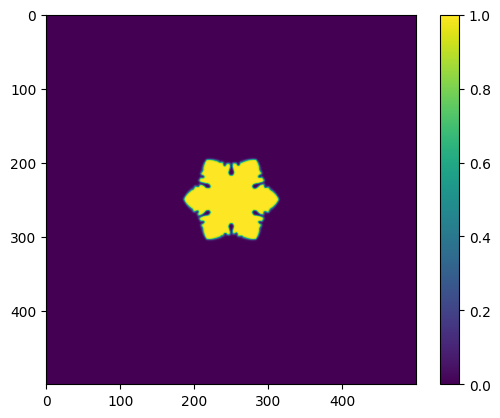

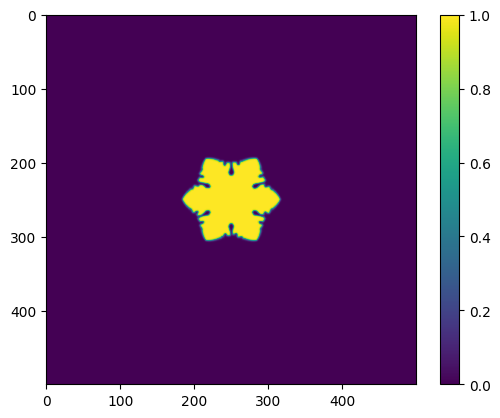

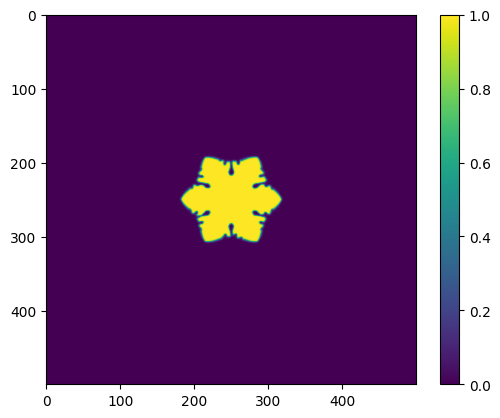

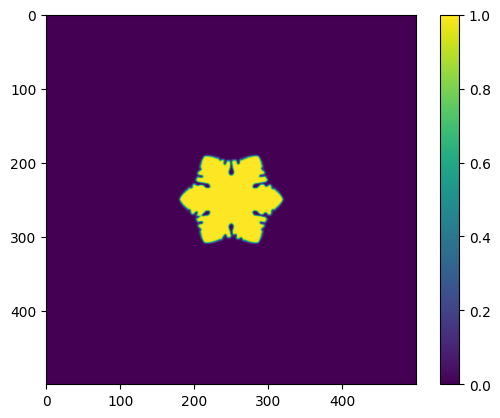

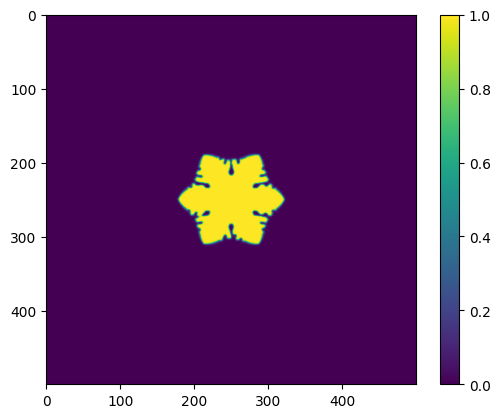

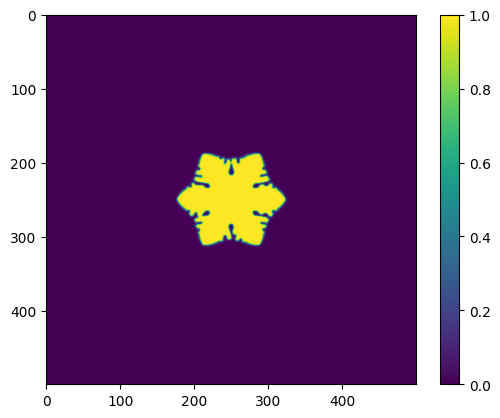

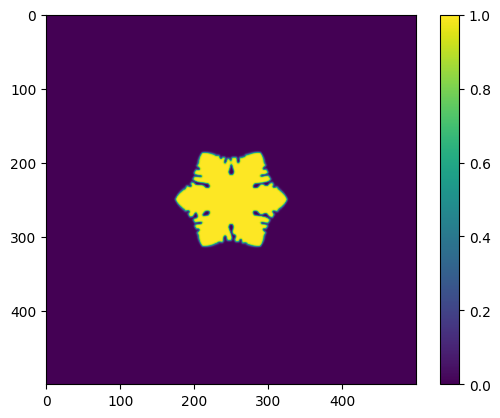

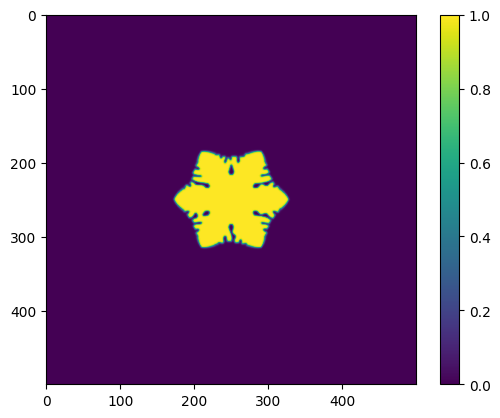

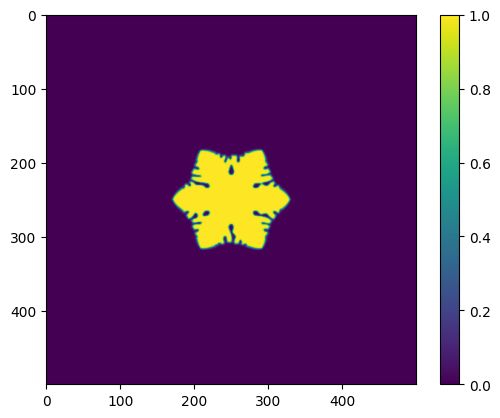

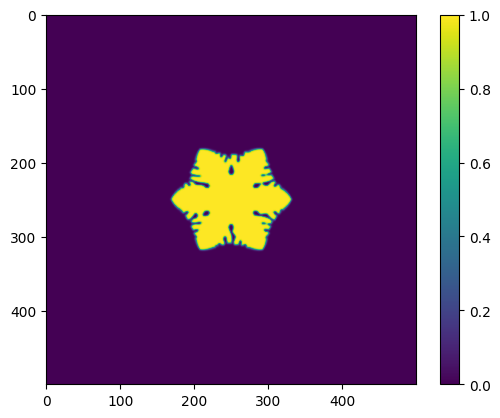

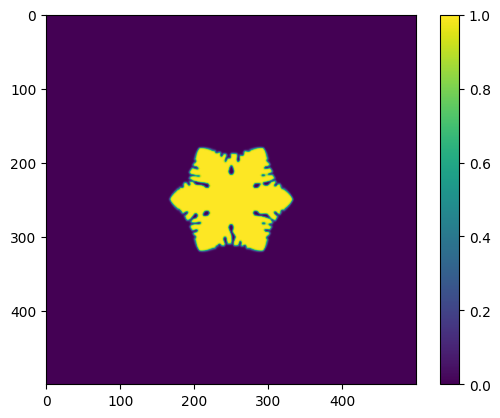

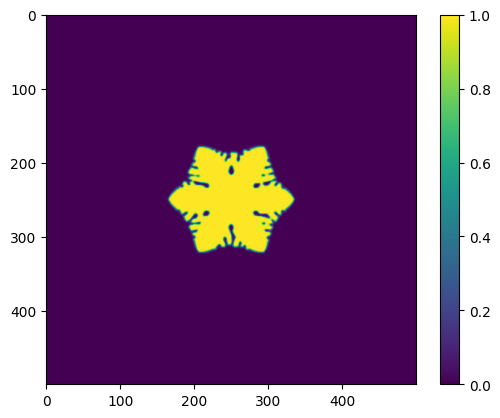

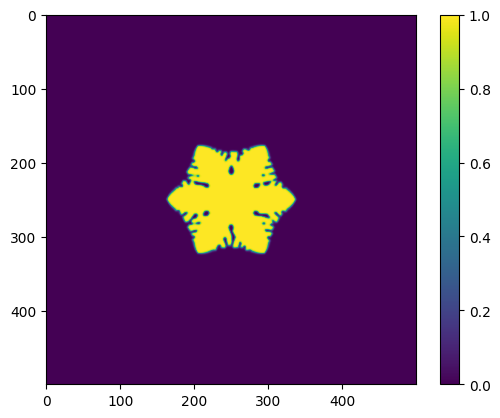

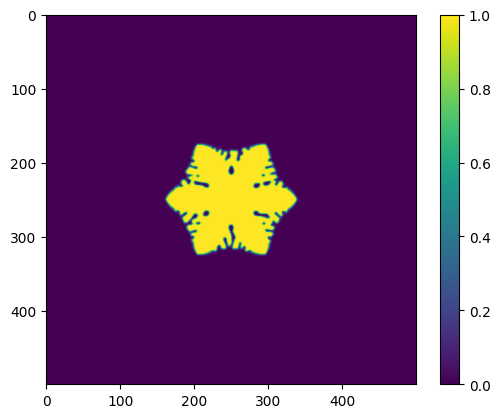

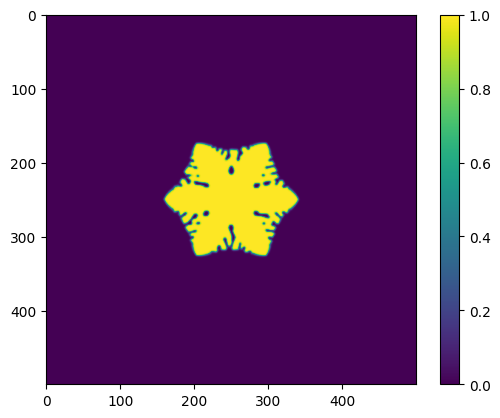

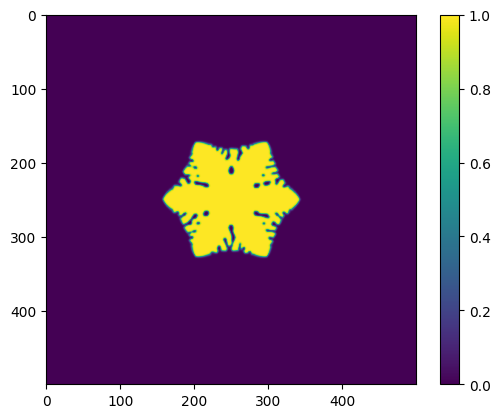

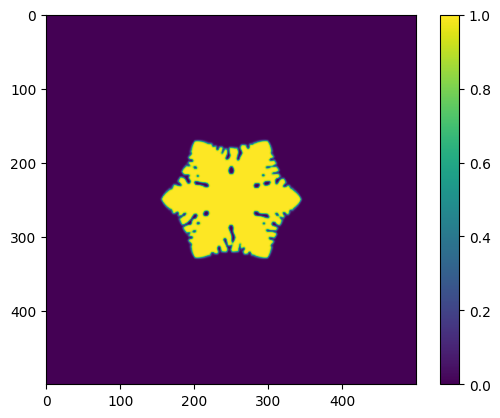

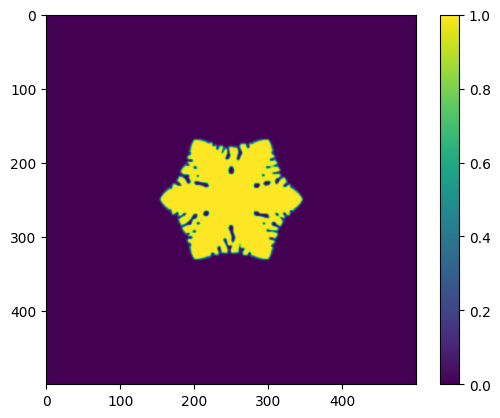

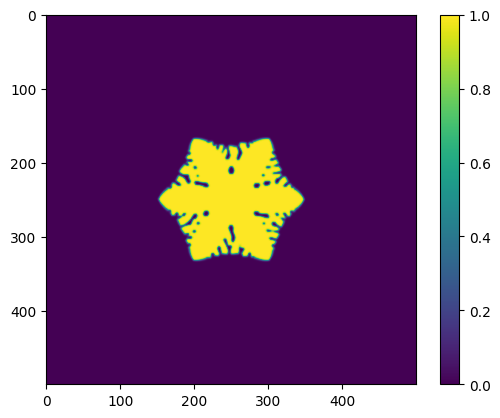

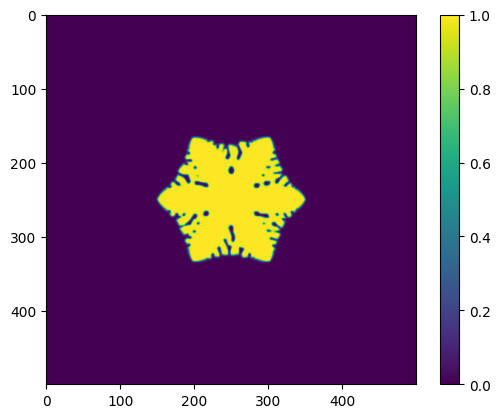

0.19980000000000367


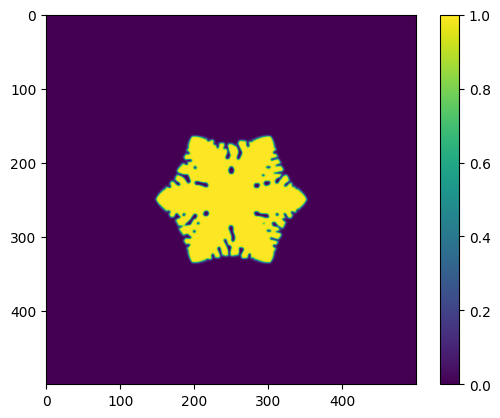

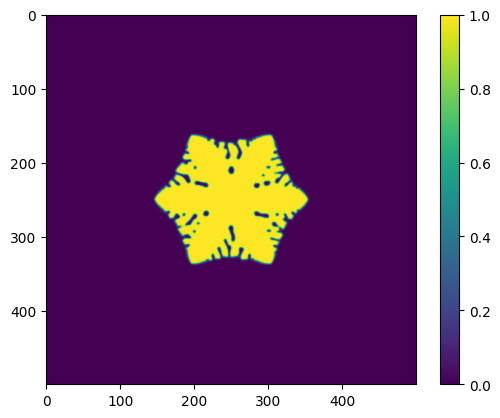

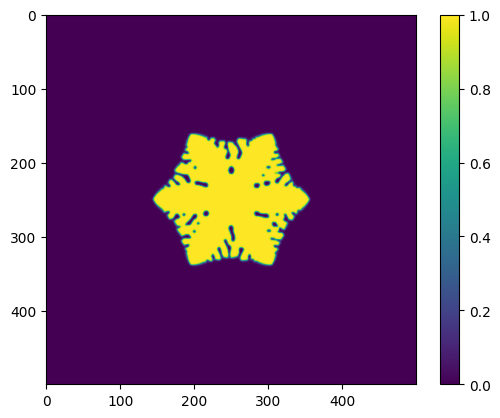

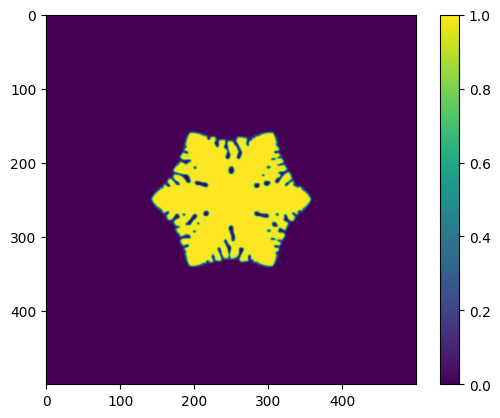

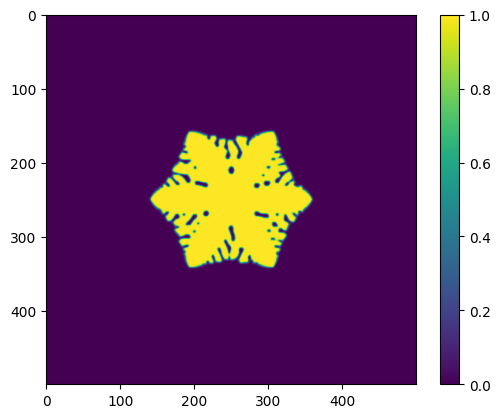

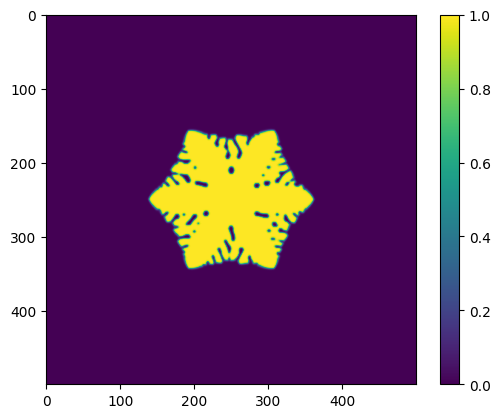

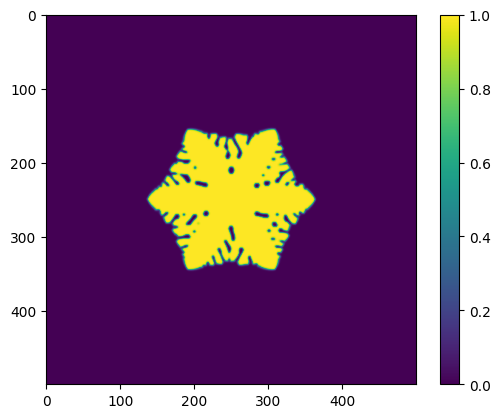

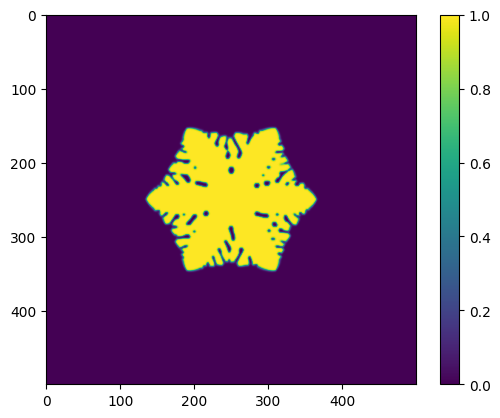

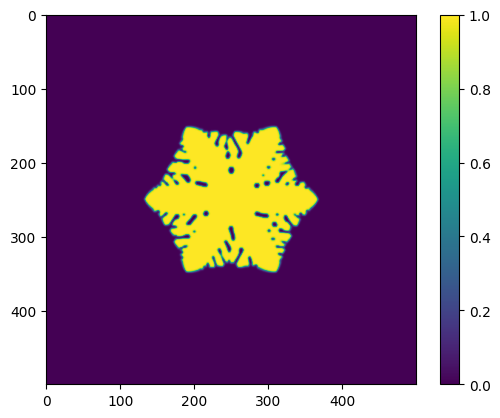

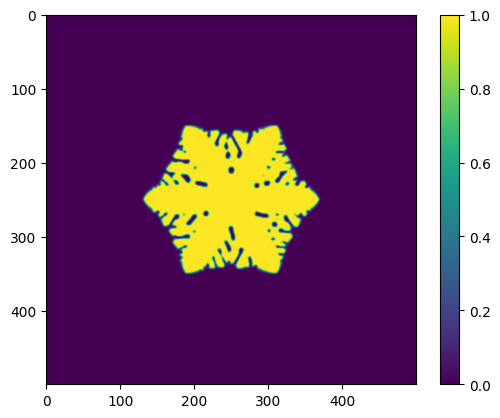

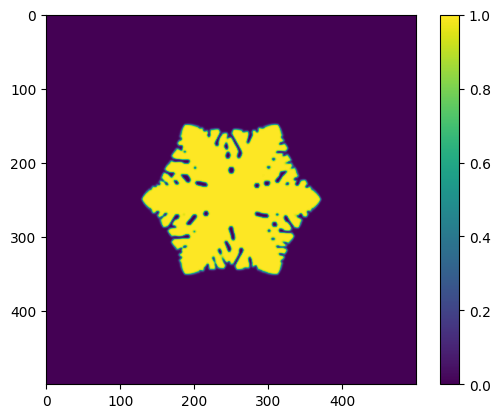

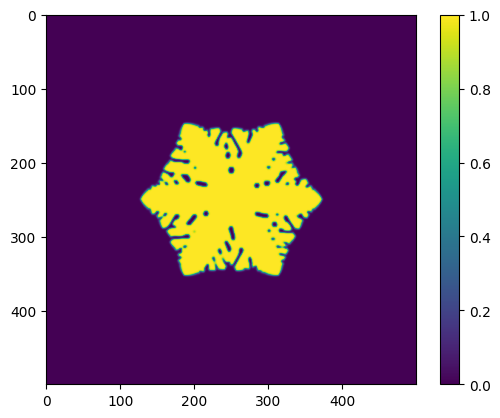

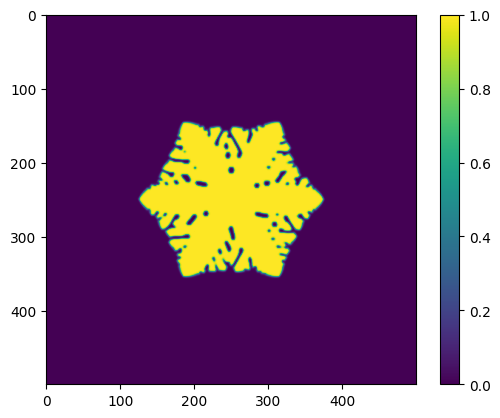

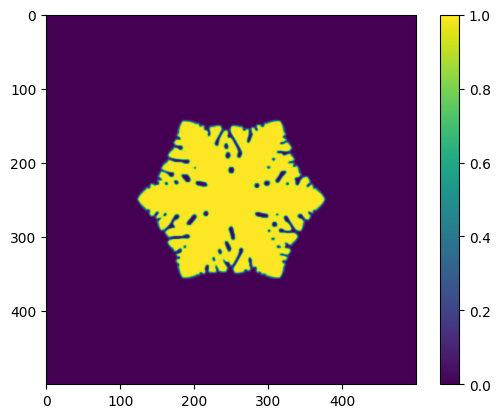

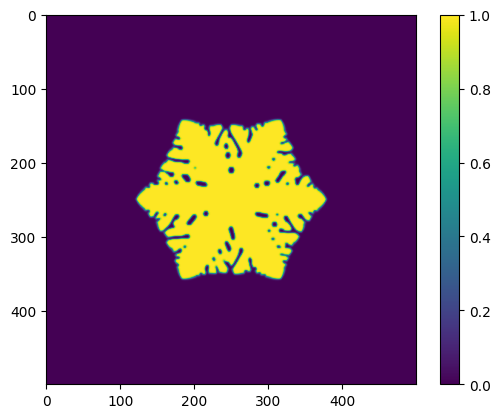

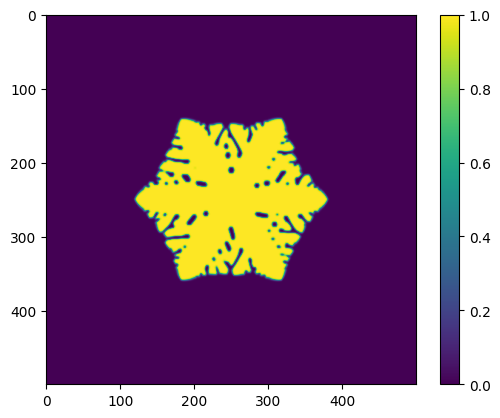

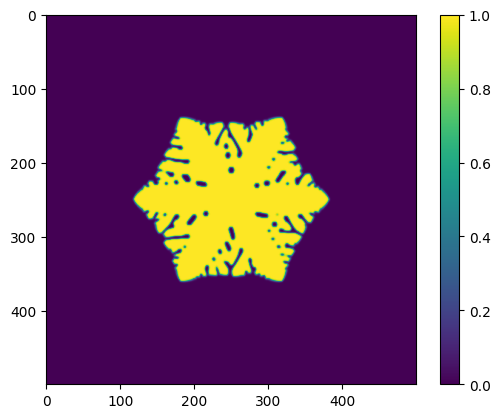

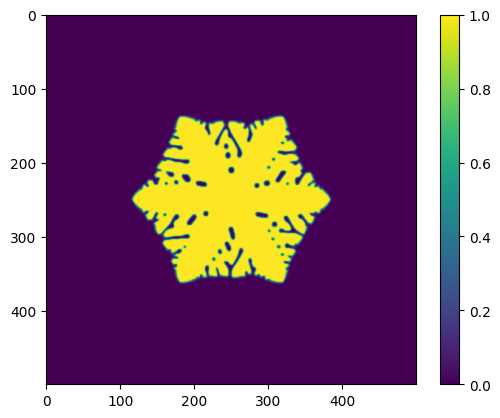

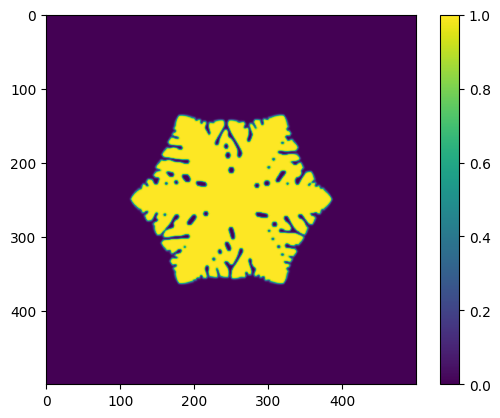

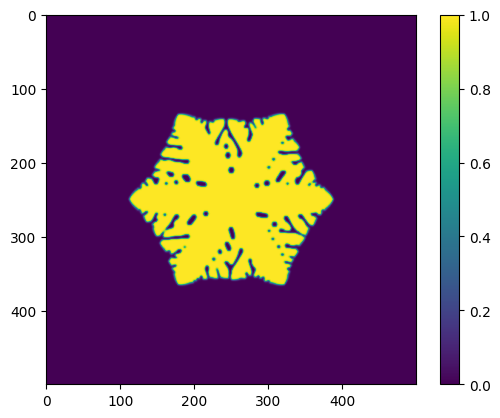

In [55]:
for i in range(nIter):
    p_x, p_y = grad(p, hx, hy)
    theta = get_theta(theta, p_x, p_y)
    eps, eps_der = get_eps(theta)
    eps2_x, eps2_y = grad(eps**2, hx, hy)
    
    p_new = phase_field(hx, hy, eps, eps_der, p_x, p_y, p, T) 
    p_new = zero_flux_BC(p_new)
    d_p = p_new - p
    
    T_new = T_field(T, d_p)
    T_new = zero_flux_BC(T_new)
    
    p = p_new
    T = T_new
    
    if (i+1) % 20 == 0:
        plt.imshow(p, cmap='viridis')
        plt.savefig(case_path + os.sep + "%s_%f.png" %(case_name, t))
        plt.colorbar()
        plt.show()
    
    if (i+1) % 1000 == 0: 
        print(t)
        
    t += dt